### Here we tune and test the model

In [10]:
import numpy as np
import pandas as pd
from recommender import CosineSimilarityRecommender, BaselineRecommender

In [2]:
data = pd.read_csv('toy_data_meetup.csv')

In [11]:
data = data[['topic_name', 'member_id']]

/Users/filipkos/env/insight/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """Entry point for launching an IPython kernel.


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [12]:
data = np.load('data_clear.npy')

In [13]:
split = int(0.7 * data.shape[0])
train = data[:split]
test = data[split:]
#mn = train.mean(axis = 0)
# sig = np.sqrt(train.var(axis = 0))
# train = (train - mn) / sig

In [14]:
csr = CosineSimilarityRecommender()

In [15]:
csr.fit(train, scaling=True, alpha=1)

In [9]:
bsr = BaselineRecommender()
bsr.fit(train)

In [26]:
def listIntersection(arr1, arr2):
    intersection_ = np.array([x for x in arr1 if x in arr2])
    return intersection_

def listDifference(arr1, arr2):
    diff_ = np.array([x for x in arr1 if x not in arr2])
    return diff_

def divideList(arr, num):
    chosen = np.random.choice(arr, num, replace=False)
    remaining = listDifference(arr, chosen)
    return chosen, remaining

def evaluate(test, recommender, baseline_recommender, h=1 , k=3, epochs=1):
    """
    Gives precision and information score for recommender relative to baseline_recommender.
    """
    precision = 0
    recall = 0
    information = 0
    baseline_precision = 0
    baseline_recall = 0
    baseline_information = 0
    score = 0
    baseline_score = 0
    probs = baseline_recommender.scores
    for epoch in range(epochs):
        total_ = 0
        count_ = 0
        score = 0
        baseline_score = 0
        for vec in test:
            if vec.sum() < h + 1:
                continue
            hobbies = np.where(vec)[0]
            selected, remaining = divideList(hobbies, h)

            user_input = np.zeros_like(vec)
            user_input[selected] = np.ones_like(selected)

            predictions = recommender.predict(user_input)[0]
            rankings = np.argsort(predictions)[::-1]
            rankings = listDifference(rankings, selected)

            baseline_predictions = baseline_recommender.predict(user_input)[0]
            baseline_rankings = np.argsort(baseline_predictions)[::-1]
            baseline_rankings = listDifference(baseline_rankings, selected)

            #Check how many were predicted correctly in top k
            score += len(listIntersection(rankings[:k], remaining))
            baseline_score += len(listIntersection(baseline_rankings[:k], remaining))
            total_ += len(remaining)
            count_ += 1
            information += -np.sum(np.log(probs[listIntersection(rankings[:k], remaining).astype(np.int)]))
            baseline_information += -np.sum(np.log(probs[listIntersection(baseline_rankings[:k], remaining).astype(np.int)]))
                    
        precision += score / (k * count_)
        recall += score / total_
        baseline_precision += baseline_score / (k * count_)
        baseline_recall += baseline_score / total_
        
    results = {"precision": precision / epochs, "recall": recall / epochs,
               "information": information / (k * count_ * epochs),
              "baseline_precision": baseline_precision / epochs, "baseline_recall": baseline_recall / epochs,
               "baseline_information": baseline_information /  (k * count_ * epochs),
               "relative_precision": precision / baseline_precision,
               "relative_recall": recall / baseline_recall,
               "relative_information": information / baseline_information
              }
    return results  

In [27]:
evaluate(test, csr, bsr, h=7 , k=3, epochs=1)

{'precision': 0.2902338376891334,
 'recall': 0.2984441301272984,
 'information': 0.5956134981499481,
 'baseline_precision': 0.14580467675378267,
 'baseline_recall': 0.14992927864214992,
 'baseline_information': 0.1677051010593295,
 'relative_precision': 1.990566037735849,
 'relative_recall': 1.9905660377358492,
 'relative_information': 3.5515526623083233}

#### Tuning the alpha hyperparameter

In [39]:
prec = {}
info = {}
for alpha in np.linspace(0, 2, 11):
    csr.fit(train, scaling=True, alpha=alpha)
    res = evaluate(train, csr, bsr, h=3 , k=3, epochs=10)
    prec[alpha] = res['precision']
    info[alpha] = res['information']

In [43]:
prec.keys()

dict_keys([0.0, 0.2, 0.4, 0.6000000000000001, 0.8, 1.0, 1.2000000000000002, 1.4000000000000001, 1.6, 1.8, 2.0])

Evaluate the performance for different values of the hyperparameter on the training data.

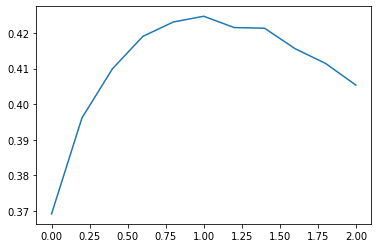

In [50]:
from matplotlib import pyplot as plt
plt.plot(np.array(list(prec.items()))[:,0], np.array(list(prec.items()))[:,1])

The value alpha = 1 looks reasonable for the hyperparameter, so we'll go with that.

#### Testing the performance of the model

Here we will look at the recommender performance on the test dataset. In particular we compute the precision and information gain of top-3 recommendations relative to the baseline recommender, as a function of number of hobbies rated.

In [8]:
csr.fit(train, scaling=True, alpha=1)
results = {}
for h in range(0,7):
    csr.fit(train, scaling=True, alpha=1)
    results[h] = evaluate(test, csr, bsr, h=h, k=3, epochs=10)

NameError: name 'csr' is not defined

In [69]:
[results[h]['relative_precision'] for h in rated]
[results[h]['relative_information'] for h in rated]

[0.9416364599097892,
 2.139428516359579,
 2.6969182858765013,
 3.0599575200589038,
 3.3358578109043022,
 3.5862012807743957,
 3.7597122740768207]

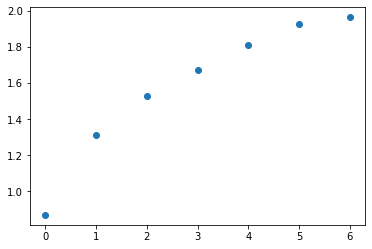

In [71]:
rated = np.array(list(results.keys()))
prec = np.array([results[h]['relative_precision'] for h in rated])
info = np.array([results[h]['relative_information'] for h in rated])
plt.plot(rated, prec, 'o')

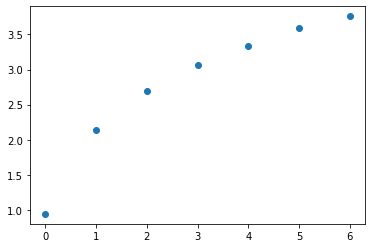

In [72]:
plt.plot(rated, info, 'o')

The cosine similarity recommender outperforms baseline by a factor of 2 in terms of precision, and factor of almost 4 in terms of information.

In [20]:
csr.similarity

array([[3.38802298e-01, 5.13347602e-02, 6.24825173e-02, ...,
        1.32109310e-03, 2.17609544e-04, 1.46256234e-09],
       [6.45926478e-02, 2.63990779e-01, 5.49713289e-02, ...,
        1.83278808e-02, 3.46140143e-04, 1.56103877e-09],
       [6.25590733e-02, 4.37417823e-02, 3.34886973e-01, ...,
        1.49296639e-03, 8.92567097e-05, 6.50742465e-04],
       ...,
       [9.56904083e-04, 1.05505642e-02, 1.08007329e-03, ...,
        5.24800184e-01, 1.05161319e-09, 1.36497809e-09],
       [1.45091686e-04, 1.83419289e-04, 5.94392981e-05, ...,
        9.68022892e-10, 5.54531936e-01, 2.61073519e-03],
       [7.27497750e-10, 6.17105485e-10, 3.23291753e-04, ...,
        9.37363332e-10, 1.94767057e-03, 7.94544128e-01]])

In [21]:
np.save("mn.npy", csr.mn)

In [22]:
np.save("sig.npy", csr.sig)

In [23]:
np.save("similarity.npy", csr.similarity)